Test the transpiration calculation by comparing it to that calculated using Manon's LeafPhysio code.

In [1]:
import sys
sys.path.append('../')

from src.vapour_pressure_deficit_calculation import vapour_pressure_deficit, saturation_vapour_pressure
from src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import CumulativeWeibullDistribution, cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.rubisco_CO2_and_O_model import RubiscoRates
from src.electron_transport_rate_model import ElectronTransportRateModel
from src.michaelis_menten_response_function import michaelis_menten_constant

# -- Temperature dependency models --
from src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan
from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan
from src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelRubiscoLimitedLeuning
from src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelElectronTransportLimitedLeuning

# -- Profit Models --
from src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from src.ProfitModels.profit_max_model import ProfitMaxModel
from src.ProfitModels.profit_optimisation_model import run_optimisation_model_on_data

from src.conversions import (magnitude_conversion,
                             mole_carbon_to_grams,
                             per_day_to_per_second,
                             per_second_to_per_half_hour,
                             convert_transpiration_rate_to_latent_energy,
                             short_wave_to_photosynthetically_active_radiation,
                             light_energy_in_joules_to_micro_moles_of_light,
                             degrees_kelvin_to_centigrade,
                             degrees_centigrade_to_kelvin,
                             convert_stomatal_conductance_of_carbon_to_water)

from xarray import open_dataset
from pandas import DataFrame, date_range
from numpy import nan

from matplotlib import pyplot as plt

## Test 1

In [2]:
kmax = 10.5324318 # mmol m-2 s-1 MPa-1
b = -3.768627098363331 # MPa
c = 1.8163880934001593

Psoil = -3.2 # MPa
Pcrit = -6.8947515680712685 # MPa

Manons_transpiration = 0.008178133968762076 # mol m-2 s-1

In [3]:
conductance_model = \
    CumulativeWeibullDistribution(maximum_conductance = kmax, # mmol m-2 s-1 MPa-1
                                  sensitivity_parameter = b, # MPa
                                  shape_parameter = c) # unitless

transpiration = conductance_model.transpiration(Pcrit, Psoil, steps = 600)

transpiration /= 1000 # convert mmol m-2 s-1 to mol m-2 s-1

print("calculated transpiration = ", transpiration, " mol m-2 s-1")
print("expected transpiration   = ", Manons_transpiration, " mol m-2 s-1")

calculated transpiration =  0.008178139350303535  mol m-2 s-1
expected transpiration   =  0.008178133968762076  mol m-2 s-1


## Test 2

In [4]:
kmax = 3.34507118 # mmol m-2 s-1 MPa-1
b = -6.074790568462852 # MPa
c = 2.5789492405623307

Psoil = -0.7 # MPa
Pcrit = -9.296032738923701 # MPa

Manons_transpiration = 0.015532801650166243 # mol m-2 s-1

In [5]:
conductance_model = \
    CumulativeWeibullDistribution(maximum_conductance = kmax, # mmol m-2 s-1 MPa-1
                                  sensitivity_parameter = b, # MPa
                                  shape_parameter = c) # unitless

transpiration = conductance_model.transpiration(Pcrit, Psoil, steps = 600)

transpiration /= 1000 # convert mmol m-2 s-1 to mol m-2 s-1

print("calculated transpiration = ", transpiration, " mol m-2 s-1")
print("expected transpiration   = ", Manons_transpiration, " mol m-2 s-1")

calculated transpiration =  0.0155328000653699  mol m-2 s-1
expected transpiration   =  0.015532801650166243  mol m-2 s-1


# Test peaked Arrhenius functions

$\text{CO}_2$ compensation point.

In [6]:
temperature_C = 26.06972433099309 # C
temperature_K = degrees_centigrade_to_kelvin(temperature_C)

print("temperature: ", temperature_K, " (K)")

print("\nArrhenius function")
CO2_compensation_point_model = ArrheniusModel(4.22, 37830.0)

print("Calculated CO2 compensation_point: ", CO2_compensation_point_model.get_value_at_temperature(temperature_K))
print("Expected CO2 compensation_point  :  4.45662592303576")

temperature:  299.2197243309931  (K)

Arrhenius function
Calculated CO2 compensation_point:  4.456625923035757
Expected CO2 compensation_point  :  4.45662592303576


$V_{\text{max}}$

In [7]:
print("\nPeaked Arrhenius function")
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 98.0,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

print("Calculated Vmax: ", maximum_carboxylation_rate_model.get_value_at_temperature(temperature_K))
print("Expected Vmax  :  104.21941179426375")


Peaked Arrhenius function
Calculated Vmax:  104.21941179426365
Expected Vmax  :  104.21941179426375


$J_{max}$

In [8]:
print("\nPeaked Arrhenius function")
maximum_electron_transport_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 1.64*98.0,
                                                             activation_energy = 30000.,
                                                             deactivation_energy = 200000.,
                                                             entropy_term = 650.)

print("Calculated Vmax: ", maximum_electron_transport_rate_model.get_value_at_temperature(temperature_K))
print("Expected Vmax  :  163.682718607573")


Peaked Arrhenius function
Calculated Vmax:  163.68271860757292
Expected Vmax  :  163.682718607573


$K_C$

In [9]:
michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade = 39.96,
                                                     activation_energy = 79430.0)

print("Calculated Kc: ", michaelis_menten_constant_CO2_model.get_value_at_temperature(temperature_K))
print("Expected Kc  :  44.80992044028015")

Calculated Kc:  44.80992044028009
Expected Kc  :  44.80992044028015


$K_O$

In [10]:
michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade = 27.48,
                                                   activation_energy = 36380.0)

print("Calculated Ko: ", michaelis_menten_constant_O_model.get_value_at_temperature(temperature_K))
print("Expected Ko  :  28.960249147044816")

Calculated Ko:  28.960249147044795
Expected Ko  :  28.960249147044816


$K_M$

In [11]:
Oi = 20.8 # mmol mol
Kc = michaelis_menten_constant_CO2_model.get_value_at_temperature(temperature_K)
Ko = michaelis_menten_constant_O_model.get_value_at_temperature(temperature_K)

print("Calculated Km: ", michaelis_menten_constant(Oi, Ko, Kc))
print("Expected Km  :  76.99356431797572")

Calculated Km:  76.99356431797564
Expected Km  :  76.99356431797572


# Test photosynthesis model

In [12]:
# -- Rubisco --
# -- Rubisco rates model --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 98.0,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 1.64 * 98.0,
                                                       activation_energy = 30000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=395.64,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=272.08,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 41.78,
                                              activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.525,
                                                                     Q10_parameter = 2.)

# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimitedLeuning(rubisco_rates_model = rubisco_rates_model,
                                                                                CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)
# -- Electron transport rate --
maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 1.64*98.0, 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                    lower_bound_C = 0.,
                                                                    upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

# Note the CO2 compensation point and mitochondrial respiration rate models are the same as that for the Rubisco limited model
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimitedLeuning(electron_transport_rate_model = electron_transport_rate_model,
                                                                                                     CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                                     mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model,
                                                                                                     rubisco_rates_model=rubisco_rates_model)
# -- Combined model --
photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model = photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model = photosynthesis_electron_transport_limited_model)

# -- Input --
stomatal_conductance_to_CO2 = 0.32392416105280475
atmospheric_CO2_concentration = 35.4374055 * 1000/101
leaf_temperature = degrees_centigrade_to_kelvin(21.52957864786499)
intercellular_O = 20.8 * 1000/101
utilized_photosynthetically_active_radiation = 499.0 * 0.3

# -- Run model --
Ac, rubisco_Ci = photosynthesis_rubisco_limited_model.net_rate_of_CO2_assimilation(stomatal_conductance_to_CO2,
                                                                                   atmospheric_CO2_concentration,
                                                                                   leaf_temperature,
                                                                                   intercellular_O,
                                                                                   utilized_photosynthetically_active_radiation)
    
Aj, elctron_transport_Ci = photosynthesis_electron_transport_limited_model.net_rate_of_CO2_assimilation(stomatal_conductance_to_CO2,
                                                                                                        atmospheric_CO2_concentration,
                                                                                                        leaf_temperature,
                                                                                                        intercellular_O,
                                                                                                        utilized_photosynthetically_active_radiation)
    
An, Full_model_Ci = photosynthesis_model.net_rate_of_CO2_assimilation(stomatal_conductance_to_CO2,
                                                                      atmospheric_CO2_concentration,
                                                                      leaf_temperature,
                                                                      intercellular_O,
                                                                      utilized_photosynthetically_active_radiation)


print("\nCalculated Ac: ", Ac, "  umol m-2 s-1")
print("Manons Ac    :  25.15 (26.305827448052224)   umol m-2 s-1")
print("Calculated Aj: ", Aj, " umol m-2 s-1")
print("Manons Aj    :  14.40 (15.563662129098175)  umol m-2 s-1")
print("Calculated An: ", An, "  umol m-2 s-1")
print("Manons An    :   14.250061012888029   umol m-2 s-1")
print("Manons Rn    :   1.159241670843702 umol m-2 s-1" )

Vmax = maximum_carboxylation_rate_model.get_value_at_temperature(leaf_temperature)
print("Rn           : ", 0.015*Vmax)


Calculated Ac:  22.707212572113075   umol m-2 s-1
Manons Ac    :  25.15 (26.305827448052224)   umol m-2 s-1
Calculated Aj:  58.77798451628828  umol m-2 s-1
Manons Aj    :  14.40 (15.563662129098175)  umol m-2 s-1
Calculated An:  22.707212572113075   umol m-2 s-1
Manons An    :   14.250061012888029   umol m-2 s-1
Manons Rn    :   1.159241670843702 umol m-2 s-1
Rn           :  1.1592416708437028


# Test full model compared to Manons code output

First we create the model.

In [13]:
hydraulic_conductance_model = \
    cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials(10.5324318,
                                                                                    -3.08,
                                                                                    -5.7,
                                                                                    0.5,
                                                                                    0.88)


critical_leaf_water_potential = hydraulic_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

print("critical leaf water potential: ", critical_leaf_water_potential, "mmol m-2 s-1 MPa-1")

hydraulic_cost_model = HydraulicCostModel(hydraulic_conductance_model = hydraulic_conductance_model,
                                          critical_leaf_water_potential = critical_leaf_water_potential)

critical leaf water potential:  -6.894751568071268 mmol m-2 s-1 MPa-1


In [14]:
leaf_air_coupling_model = LeafAirCouplingModel()

In [15]:
# -- Rubisco rates model --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 71.66,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 60.,
                                                       activation_energy = 30000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=395.64,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=272.08,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 41.78,
                                              activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.525,
                                                                     Q10_parameter = 2.)

mitochondrial_respiration_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 0.015*71.66,
                                                            activation_energy = 60000.,
                                                            deactivation_energy = 200000.,
                                                            entropy_term = 650.)

# -- Rubisco limited model --
photosynthesis_rubisco_limited_model_Leuning = PhotosynthesisModelRubiscoLimitedLeuning(rubisco_rates_model = rubisco_rates_model,
                                                                                        CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                        mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)

photosynthesis_rubisco_limited_model_Bonan = PhotosynthesisModelRubiscoLimitedBonan(rubisco_rates_model = rubisco_rates_model,
                                                                                    CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                    mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)

In [16]:
# -- Electron transport rate --
maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 71.66*1.64, 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                   lower_bound_C = 0.,
                                                                   upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

# -- Electron transport rate limmited model --
# Note the CO2 compensation point and mitochondrial respiration rate models are the same as that for the Rubisco limited model
photosynthesis_electron_transport_limited_model_Leuning = PhotosynthesisModelElectronTransportLimitedLeuning(electron_transport_rate_model = electron_transport_rate_model,
                                                                                                             CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                                             mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model,
                                                                                                             rubisco_rates_model=rubisco_rates_model)

photosynthesis_electron_transport_limited_model_Bonan = PhotosynthesisModelElectronTransportLimitedBonan(electron_transport_rate_model = electron_transport_rate_model,
                                                                                                         CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                                         mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model,
                                                                                                         rubisco_rates_model=rubisco_rates_model)

In [17]:
photosynthesis_model_Leuning = PhotosynthesisModel(photosynthesis_rubisco_limited_model = photosynthesis_rubisco_limited_model_Leuning,
                                                   photosynthesis_electron_transport_limited_model = photosynthesis_electron_transport_limited_model_Leuning)

photosynthesis_model_Bonan = PhotosynthesisModel(photosynthesis_rubisco_limited_model = photosynthesis_rubisco_limited_model_Bonan,
                                                 photosynthesis_electron_transport_limited_model = photosynthesis_electron_transport_limited_model_Bonan)

In [18]:
# -- Leuning --
CO2_gain_model_Leuning = CO2GainModel(leaf_air_coupling_model,
                                      photosynthesis_model_Leuning)

CO2_gain_model_rubisco_limited_Leuning = CO2GainModel(leaf_air_coupling_model,
                                                      photosynthesis_rubisco_limited_model_Leuning)

CO2_gain_model_elcetron_transport_limited_Leuning = CO2GainModel(leaf_air_coupling_model,
                                                                 photosynthesis_electron_transport_limited_model_Leuning)

# -- Bonan --
CO2_gain_model_Bonan = CO2GainModel(leaf_air_coupling_model,
                                    photosynthesis_model_Bonan)

CO2_gain_model_rubisco_limited_Bonan = CO2GainModel(leaf_air_coupling_model,
                                                    photosynthesis_rubisco_limited_model_Bonan)

CO2_gain_model_elcetron_transport_limited_Bonan = CO2GainModel(leaf_air_coupling_model,
                                                               photosynthesis_electron_transport_limited_model_Bonan)

In [19]:
# -- Leuning --
profit_optimisation_model_Leuning = ProfitMaxModel(hydraulic_cost_model,
                                                            leaf_air_coupling_model,
                                                            CO2_gain_model_Leuning)

profit_optimisation_model_rubisco_limited_Leuning = ProfitMaxModel(hydraulic_cost_model,
                                                                            leaf_air_coupling_model,
                                                                            CO2_gain_model_rubisco_limited_Leuning)

profit_optimisation_model_electron_transport_limited_Leuning = ProfitMaxModel(hydraulic_cost_model,
                                                                                       leaf_air_coupling_model,
                                                                                       CO2_gain_model_elcetron_transport_limited_Leuning)

# -- Bonan --
profit_optimisation_model_Bonan = ProfitMaxModel(hydraulic_cost_model,
                                                          leaf_air_coupling_model,
                                                          CO2_gain_model_Bonan)

profit_optimisation_model_rubisco_limited_Bonan = ProfitMaxModel(hydraulic_cost_model,
                                                                          leaf_air_coupling_model,
                                                                          CO2_gain_model_rubisco_limited_Bonan)

profit_optimisation_model_electron_transport_limited_Bonan = ProfitMaxModel(hydraulic_cost_model,
                                                                                     leaf_air_coupling_model,
                                                                                     CO2_gain_model_elcetron_transport_limited_Bonan)


In [20]:
soil_water_potential = -0.7
air_temperature = degrees_centigrade_to_kelvin(21.)
air_vapour_pressure_deficit = 1.07
air_pressure = 101.7
atmospheric_CO2_concentration = 39.32549906 * 1000/air_pressure
intercellular_oxygen = 20.8
photosynthetically_active_radiation = 498.


profit_optimisation_model_Leuning.optimal_state(soil_water_potential,
                                        air_temperature,
                                        air_vapour_pressure_deficit,
                                        air_pressure,
                                        atmospheric_CO2_concentration,
                                        intercellular_oxygen,
                                        photosynthetically_active_radiation,
                                        number_of_sample_points=10)

(-1.3883057297856962,
 25.23331820139573,
 6.56480743876667,
 323.19001453602567,
 0.39742896393985966)

## Import data

To properly test the code we need to repeat the above with a full set of time series data.

In [21]:
import pandas as pd

input_file = "/Users/jb14389/Desktop/Training/Getting started with tree models/Examples from Manon/Leaf_Physio/input/all_site_spp/Corrigin_Eucalyptus_capillosa.csv"

input_data = pd.read_csv(input_file, skiprows = [1])[['Ps', 'VPD', 'Patm', 'CO2', 'PPFD', 'Tair']]

print(input_data)

      Ps   VPD   Patm        CO2  PPFD   Tair
0   -3.3  1.70  98.83  34.836548  1700  20.87
1   -3.3  2.84  98.76  34.476844  2092  27.11
2   -3.3  2.70  98.76  35.003735   268  26.80
3   -3.3  1.70  98.83  34.799058  1701  20.92
4   -3.8  1.80  98.83  34.482924  1495  21.76
..   ...   ...    ...        ...   ...    ...
127 -4.4  6.22  97.56  36.238886   103  37.50
128 -3.8  6.28  97.60  36.256112   200  37.65
129 -3.8  6.30  97.59  36.273337   151  37.81
130 -4.4  6.78  97.56  36.251045   978  38.02
131 -4.4  6.81  97.56  36.396953  1158  38.09

[132 rows x 6 columns]


We need to drop the first row containing units and convert Tair to $k$ and $\text{CO}_2$ to $\mu
\text{mol}$ $\text{mol}^{-1}$

In [22]:
input_data['CO2'] = input_data['CO2'] * 1000/input_data['Patm']

print(input_data)

      Ps   VPD   Patm         CO2  PPFD   Tair
0   -3.3  1.70  98.83  352.489611  1700  20.87
1   -3.3  2.84  98.76  349.097251  2092  27.11
2   -3.3  2.70  98.76  354.432306   268  26.80
3   -3.3  1.70  98.83  352.110270  1701  20.92
4   -3.8  1.80  98.83  348.911505  1495  21.76
..   ...   ...    ...         ...   ...    ...
127 -4.4  6.22  97.56  371.452299   103  37.50
128 -3.8  6.28  97.60  371.476552   200  37.65
129 -3.8  6.30  97.59  371.691124   151  37.81
130 -4.4  6.78  97.56  371.576930   978  38.02
131 -4.4  6.81  97.56  373.072502  1158  38.09

[132 rows x 6 columns]


We need to get Tleaf from Mannon's output file and convert both it and the air temperature to degrees Kelvin.

In [23]:
Manons_results_file = "/Users/jb14389/Desktop/Training/Getting started with tree models/Examples from Manon/Leaf_Physio/output/all_site_spp/Corrigin_Eucalyptus_capillosa.csv"

input_data['Tleaf'] = pd.read_csv(Manons_results_file, skiprows = [1])['Tleaf(pmax)']

input_data['Tleaf'] = degrees_centigrade_to_kelvin(input_data['Tleaf'])
input_data['Tair']  = degrees_centigrade_to_kelvin(input_data['Tair'])

print(input_data)

      Ps   VPD   Patm         CO2  PPFD    Tair       Tleaf
0   -3.3  1.70  98.83  352.489611  1700  294.02  296.507967
1   -3.3  2.84  98.76  349.097251  2092  300.26  303.372940
2   -3.3  2.70  98.76  354.432306   268  299.95  299.480316
3   -3.3  1.70  98.83  352.110270  1701  294.07  296.554030
4   -3.8  1.80  98.83  348.911505  1495  294.91  297.122376
..   ...   ...    ...         ...   ...     ...         ...
127 -4.4  6.22  97.56  371.452299   103  310.65  309.735462
128 -3.8  6.28  97.60  371.476552   200  310.80  309.896317
129 -3.8  6.30  97.59  371.691124   151  310.96  310.000020
130 -4.4  6.78  97.56  371.576930   978  311.17  311.998927
131 -4.4  6.81  97.56  373.072502  1158  311.24  312.462547

[132 rows x 7 columns]


We also need to calculate the VPD based on the leaf temperature calculated by Manon, currently it is based on the air temperature.

In [24]:
input_data['VPDleaf'] = saturation_vapour_pressure(input_data['Tleaf'].to_numpy()) - (saturation_vapour_pressure(input_data['Tair'].to_numpy()) - input_data['VPD'].to_numpy())

print(input_data)

      Ps   VPD   Patm         CO2  PPFD    Tair       Tleaf   VPDleaf
0   -3.3  1.70  98.83  352.489611  1700  294.02  296.507967  2.103615
1   -3.3  2.84  98.76  349.097251  2092  300.26  303.372940  3.549188
2   -3.3  2.70  98.76  354.432306   268  299.95  299.480316  2.603921
3   -3.3  1.70  98.83  352.110270  1701  294.07  296.554030  2.104006
4   -3.8  1.80  98.83  348.911505  1495  294.91  297.122376  2.173460
..   ...   ...    ...         ...   ...     ...         ...       ...
127 -4.4  6.22  97.56  371.452299   103  310.65  309.735462  5.906794
128 -3.8  6.28  97.60  371.476552   200  310.80  309.896317  5.968236
129 -3.8  6.30  97.59  371.691124   151  310.96  310.000020  5.966750
130 -4.4  6.78  97.56  371.576930   978  311.17  311.998927  7.083032
131 -4.4  6.81  97.56  373.072502  1158  311.24  312.462547  7.262548

[132 rows x 8 columns]


## Run the model

In [25]:
import numpy as np

leaf_water_potential = np.zeros([len(input_data),3,2])
net_CO2_uptake = np.zeros([len(input_data),3,2])
transpiration_rate = np.zeros([len(input_data),3,2])
intercellular_CO2 = np.zeros([len(input_data),3,2])
stomatal_conductance_to_CO2 = np.zeros([len(input_data),3,2])

for i, row in input_data.iterrows():
    
    # -- Leuning --
    
    (leaf_water_potential[i,0,0],
     net_CO2_uptake[i,0,0],
     transpiration_rate[i,0,0],
     intercellular_CO2[i,0,0],
     stomatal_conductance_to_CO2[i,0,0]) = \
        profit_optimisation_model_Leuning.optimal_state(row['Ps'],
                                                        row['Tleaf'],
                                                        row['VPDleaf'],
                                                        row['Patm'],
                                                        row['CO2'],
                                                        intercellular_oxygen,
                                                        row['PPFD'],
                                                        number_of_sample_points=600)
    
    (leaf_water_potential[i,1,0],
     net_CO2_uptake[i,1,0],
     transpiration_rate[i,1,0],
     intercellular_CO2[i,1,0],
     stomatal_conductance_to_CO2[i,1,0]) = \
        profit_optimisation_model_rubisco_limited_Leuning.optimal_state(row['Ps'],
                                                                        row['Tleaf'],
                                                                        row['VPDleaf'],
                                                                        row['Patm'],
                                                                        row['CO2'],
                                                                        intercellular_oxygen,
                                                                        row['PPFD'],
                                                                        number_of_sample_points=600)
    
    (leaf_water_potential[i,2,0],
     net_CO2_uptake[i,2,0],
     transpiration_rate[i,2,0],
     intercellular_CO2[i,2,0],
     stomatal_conductance_to_CO2[i,2,0]) = \
        profit_optimisation_model_electron_transport_limited_Leuning.optimal_state(row['Ps'],
                                                                                   row['Tleaf'],
                                                                                   row['VPDleaf'],
                                                                                   row['Patm'],
                                                                                   row['CO2'],
                                                                                   intercellular_oxygen,
                                                                                   row['PPFD'],
                                                                                   number_of_sample_points=600)

    # -- Bonan --
    
    (leaf_water_potential[i,0,1],
     net_CO2_uptake[i,0,1],
     transpiration_rate[i,0,1],
     intercellular_CO2[i,0,1],
     stomatal_conductance_to_CO2[i,0,1]) = \
        profit_optimisation_model_Bonan.optimal_state(row['Ps'],
                                                      row['Tleaf'],
                                                      row['VPDleaf'],
                                                      row['Patm'],
                                                      row['CO2'],
                                                      intercellular_oxygen,
                                                      row['PPFD'],
                                                      number_of_sample_points=600)
    
    (leaf_water_potential[i,1,1],
     net_CO2_uptake[i,1,1],
     transpiration_rate[i,1,1],
     intercellular_CO2[i,1,1],
     stomatal_conductance_to_CO2[i,1,1]) = \
        profit_optimisation_model_rubisco_limited_Bonan.optimal_state(row['Ps'],
                                                                      row['Tleaf'],
                                                                      row['VPDleaf'],
                                                                      row['Patm'],
                                                                      row['CO2'],
                                                                      intercellular_oxygen,
                                                                      row['PPFD'],
                                                                      number_of_sample_points=600)
    
    (leaf_water_potential[i,2,1],
     net_CO2_uptake[i,2,1],
     transpiration_rate[i,2,1],
     intercellular_CO2[i,2,1],
     stomatal_conductance_to_CO2[i,2,1]) = \
        profit_optimisation_model_electron_transport_limited_Bonan.optimal_state(row['Ps'],
                                                                                 row['Tleaf'],
                                                                                 row['VPDleaf'],
                                                                                 row['Patm'],
                                                                                 row['CO2'],
                                                                                 intercellular_oxygen,
                                                                                 row['PPFD'],
                                                                                 number_of_sample_points=600)

/Users/jb14389/Desktop/Training/Getting started with tree models/profit-optimisation-model/note books/../src/ProfitModels/CO2GainModels/CO2_gain_profit_max_model.py:13: RuntimeWarning: All-NaN slice encountered
  maximum_CO2_uptake = nanmax(net_CO2_uptake)


## comparison results

now we load the output from Manon's code to compare to. 

In [26]:
Manons_results_file = "/Users/jb14389/Desktop/Training/Getting started with tree models/Examples from Manon/Leaf_Physio/output/all_site_spp/Corrigin_Eucalyptus_capillosa.csv"

Manons_results = pd.read_csv(Manons_results_file, skiprows = [1])

Manons_results['Ci(pmax)'] *= 1000/101

print(Manons_results)

     doy        hod     A(std)    A(pmax)    E(std)   E(pmax)   gs(std)  \
0     89   9.000000  12.007118  11.799591  2.882695  2.779519  0.143806   
1     89   9.000000   8.215851   8.280564  3.151846  3.187667  0.090550   
2     89   9.000000   5.811730   6.247144  1.653398  2.073271  0.063628   
3     89   9.000000  11.987448  11.816734  2.882462  2.800522  0.143694   
4     89   9.000000  11.200470  10.324112  2.636399  2.199630  0.125480   
..   ...        ...        ...        ...       ...       ...       ...   
127   45  17.666667   0.103843   1.339814  0.043446  1.130852  0.000707   
128   45  17.666667   1.218324   2.657671  0.569282  1.944258  0.009160   
129   45  17.666667   0.860322   2.138944  0.401417  1.751580  0.006457   
130   45  17.666667   0.245957   1.984508  0.121636  1.448283  0.001648   
131   45  17.666667   0.165766   1.861074  0.083671  1.431868  0.001105   

     gs(pmax)  gb(std)  gb(pmax)    Ci(std)    Ci(pmax)  Tleaf(std)  \
0    0.137226     2.84      

## Leaf water potential

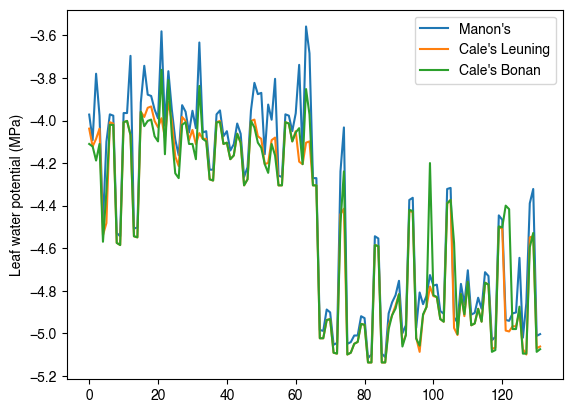

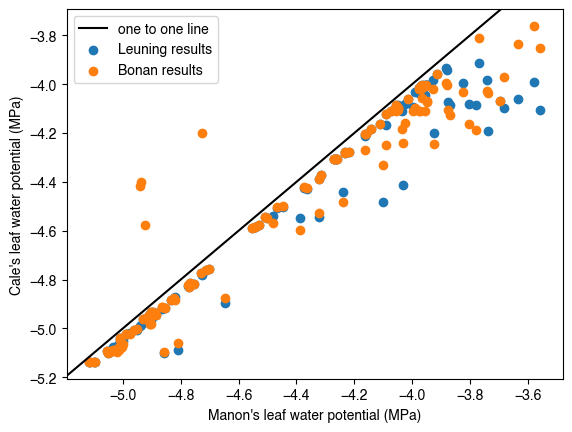

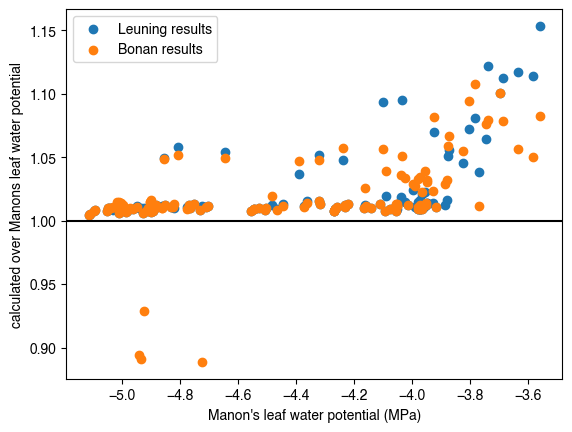

Mean ratio:  1.0218496477066425
STD in ratio:  0.02778542697018343


In [27]:
x = [i for i in range(len(input_data))]

# Plot leaf water potential
plt.plot(x, Manons_results['Pleaf(pmax)'].to_numpy(), label = "Manon's")
plt.plot(x, leaf_water_potential[:,0,0], label = "Cale's Leuning")
plt.plot(x, leaf_water_potential[:,0,1], label = "Cale's Bonan")
plt.ylabel("Leaf water potential (MPa)")
plt.legend()
plt.show()

plt.axline([-4,-4], slope = 1, c = 'black', label = 'one to one line')
plt.scatter(Manons_results['Pleaf(pmax)'].to_numpy(), leaf_water_potential[:,0,0], label = 'Leuning results')
plt.scatter(Manons_results['Pleaf(pmax)'].to_numpy(), leaf_water_potential[:,0,1], label = 'Bonan results')
plt.legend()
plt.xlabel("Manon's leaf water potential (MPa)")
plt.ylabel("Cale's leaf water potential (MPa)")
plt.show()

plt.scatter(Manons_results['Pleaf(pmax)'], leaf_water_potential[:,0,0]/Manons_results['Pleaf(pmax)'], label = 'Leuning results')
plt.scatter(Manons_results['Pleaf(pmax)'], leaf_water_potential[:,0,1]/Manons_results['Pleaf(pmax)'], label = 'Bonan results')
plt.legend()
plt.xlabel("Manon's leaf water potential (MPa)")
plt.ylabel("calculated over Manons leaf water potential")
plt.axline([-4., 1.  ], slope = 0., c = 'black')
#plt.axline([-4., 1.01], slope = 0., c = 'black')
plt.show()

print("Mean ratio: ", np.mean(leaf_water_potential[:,0,0]/Manons_results['Pleaf(pmax)']))
print("STD in ratio: ", np.std(leaf_water_potential[:,0,0]/Manons_results['Pleaf(pmax)']))

## Transpiration rate

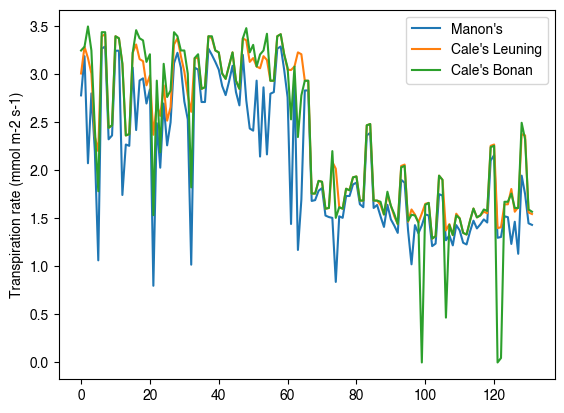

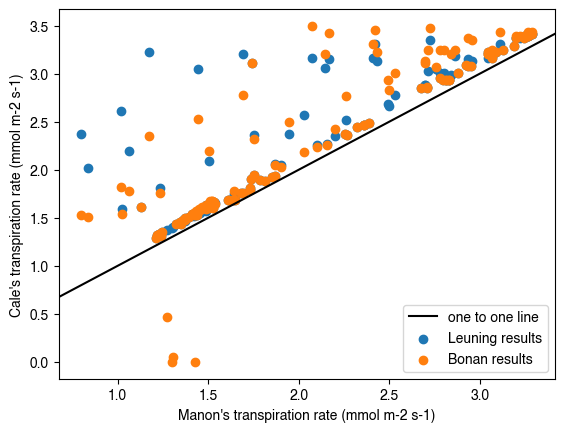

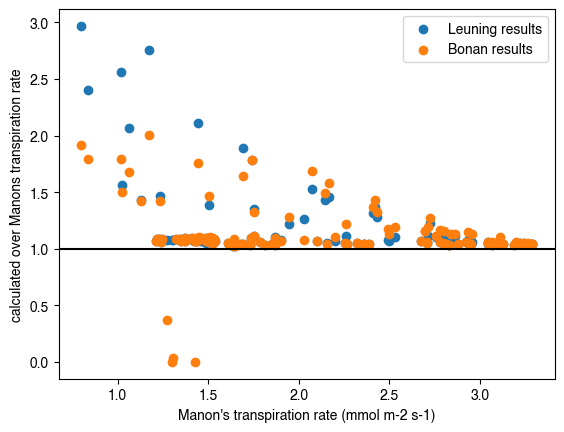

Mean ratio:  1.1721675852268938
STD of ratio:  0.3242219620042772


In [28]:
# Plot transpiration rate
plt.plot(x, Manons_results['E(pmax)'].to_numpy(), label = "Manon's")
plt.plot(x, transpiration_rate[:,0,0], label = "Cale's Leuning")
plt.plot(x, transpiration_rate[:,0,1], label = "Cale's Bonan")
plt.ylabel("Transpiration rate (mmol m-2 s-1)")
plt.legend()
plt.show()

plt.axline([2,2], slope = 1, c = 'black', label = 'one to one line')
plt.scatter(Manons_results['E(pmax)'].to_numpy(), transpiration_rate[:,0,0], label = 'Leuning results')
plt.scatter(Manons_results['E(pmax)'].to_numpy(), transpiration_rate[:,0,1], label = 'Bonan results')
plt.legend()
plt.xlabel("Manon's transpiration rate (mmol m-2 s-1)")
plt.ylabel("Cale's transpiration rate (mmol m-2 s-1)")
plt.show()


plt.scatter(Manons_results['E(pmax)'], transpiration_rate[:,0,0]/Manons_results['E(pmax)'], label = 'Leuning results')
plt.scatter(Manons_results['E(pmax)'], transpiration_rate[:,0,1]/Manons_results['E(pmax)'], label = 'Bonan results')
plt.legend()
plt.xlabel("Manon's transpiration rate (mmol m-2 s-1)")
plt.ylabel("calculated over Manons transpiration rate")
plt.axline([2,1], slope = 0., c = 'black')
#plt.axline([2,1.1], slope = 0., c = 'black')
plt.show()

print("Mean ratio: ", np.mean(transpiration_rate[:,0,0]/Manons_results['E(pmax)']))
print("STD of ratio: ", np.std (transpiration_rate[:,0,0]/Manons_results['E(pmax)']))

## Stomatal conductance

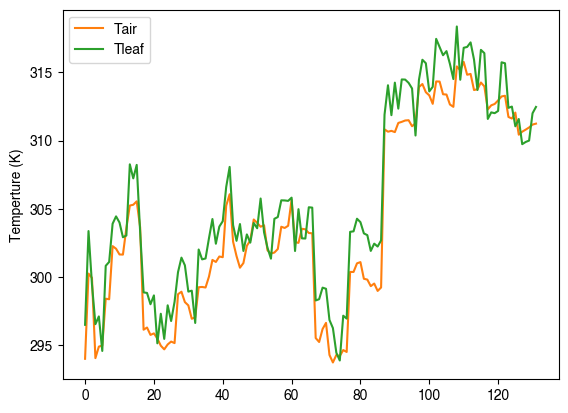

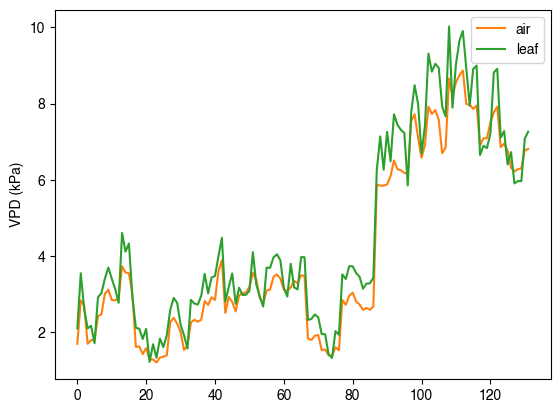

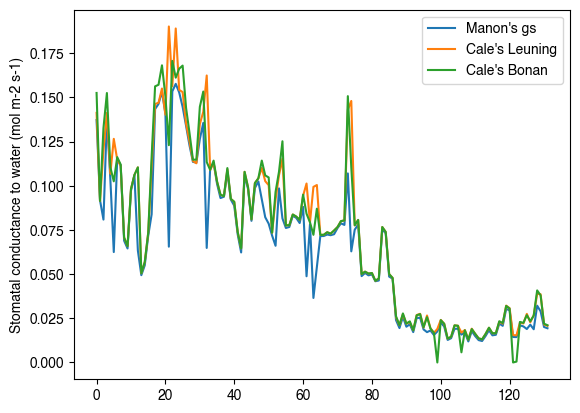

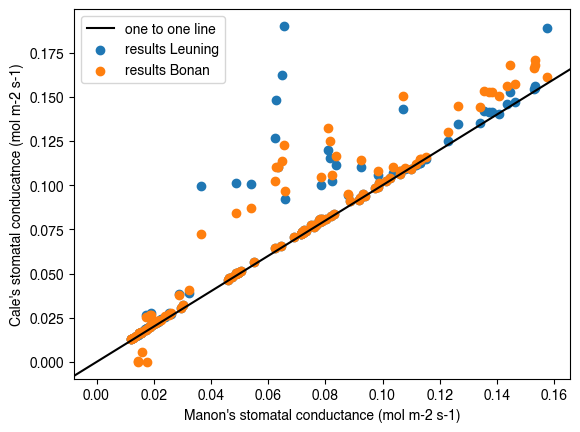

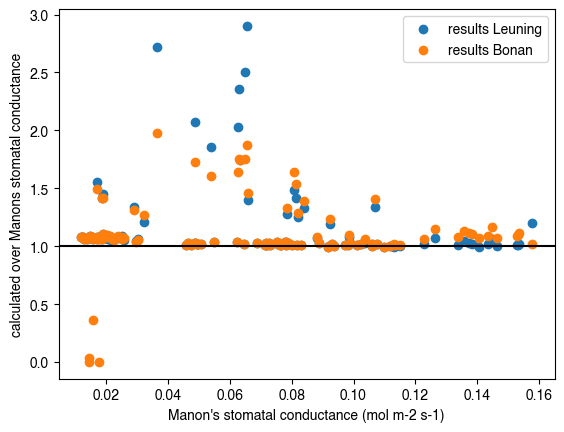

Mean ratio:  1.1453501223004527
STD of ratio:  0.3195184055677421


In [29]:
conductance_to_water = (Manons_results['E(pmax)'].to_numpy()/1000) * (input_data['Patm'].to_numpy() / input_data['VPD'].to_numpy())

leaf_VPD = saturation_vapour_pressure(input_data['Tleaf'].to_numpy()) - (saturation_vapour_pressure(input_data['Tair'].to_numpy()) - input_data['VPD'].to_numpy())

'''print(input_data['Tair'])
print(saturation_vapour_pressure(input_data['Tair'].to_numpy()))
print(input_data['Tleaf'])
print(saturation_vapour_pressure(input_data['Tleaf'].to_numpy()))
print(input_data['VPD'])
print(leaf_VPD)'''

conductance_to_water_leaf_vpd = (Manons_results['E(pmax)'].to_numpy()/1000) * (input_data['Patm'].to_numpy() / leaf_VPD)

# Manon seperates conductance between stomata and boundry. Since we don't do that ours is equivilent to the full conductance gw
Manons_results['gw(pmax)'] = (Manons_results['gb(pmax)']**(-1) + Manons_results['gs(pmax)']**(-1))**(-1)

#print(Manons_results['gb(pmax)'])

plt.plot(x, input_data['Tair'], label = 'Tair', c = '#ff7f0e')
plt.plot(x, input_data['Tleaf'], label = 'Tleaf', c = '#2ca02c')
plt.legend()
plt.ylabel("Temperture (K)")
plt.show()

plt.plot(x, input_data['VPD'], label = 'air', c = '#ff7f0e')
plt.plot(x, leaf_VPD, label = 'leaf', c = '#2ca02c')
plt.legend()
plt.ylabel("VPD (kPa)")
plt.show()

# Stomatal conductance to CO2
plt.plot(x, Manons_results['gs(pmax)'].to_numpy(), label = "Manon's gs")
plt.plot(x, stomatal_conductance_to_CO2[:,0,0]*1.57, label = "Cale's Leuning")
plt.plot(x, stomatal_conductance_to_CO2[:,0,1]*1.57, label = "Cale's Bonan")
#plt.plot(x, conductance_to_water, label = "recalculated from air VPD")
#plt.plot(x, conductance_to_water_leaf_vpd, label = "recalculated from leaf VPD")
#plt.plot(x, Manons_results['gb(pmax)'].to_numpy(), label = "Manon's gb")
#plt.plot(x, Manons_results['gw(pmax)'].to_numpy(), label = "Manon's gw")
plt.ylabel("Stomatal conductance to water (mol m-2 s-1)")
plt.legend()
plt.show()

plt.axline([0,0], slope = 1, c = 'black', label = 'one to one line')
plt.scatter(Manons_results['gs(pmax)'].to_numpy(), stomatal_conductance_to_CO2[:,0,0]*1.57, label = 'results Leuning')
plt.scatter(Manons_results['gs(pmax)'].to_numpy(), stomatal_conductance_to_CO2[:,0,1]*1.57, label = 'results Bonan')
plt.legend()
plt.xlabel("Manon's stomatal conductance (mol m-2 s-1)")
plt.ylabel("Cale's stomatal conducatnce (mol m-2 s-1)")
plt.show()

plt.scatter(Manons_results['gs(pmax)'], stomatal_conductance_to_CO2[:,0,0]*1.57/Manons_results['gs(pmax)'], label = 'results Leuning')
plt.scatter(Manons_results['gs(pmax)'], stomatal_conductance_to_CO2[:,0,1]*1.57/Manons_results['gs(pmax)'], label = 'results Bonan')
#plt.scatter(Manons_results['gs(pmax)'], (conductance_to_water/1.57)/Manons_results['gs(pmax)'])
plt.legend()
plt.xlabel("Manon's stomatal conductance (mol m-2 s-1)")
plt.ylabel("calculated over Manons stomatal conductance")
plt.axline([0.1,1], slope = 0., c = 'black')
#plt.axline([0.1,0.7], slope = 0., c = 'black')
plt.show()

print("Mean ratio: ", np.mean(stomatal_conductance_to_CO2[:,0,0]*1.57/Manons_results['gs(pmax)'].to_numpy()))
print("STD of ratio: ", np.std(stomatal_conductance_to_CO2[:,0,0]*1.57/Manons_results['gs(pmax)'].to_numpy()))

## Intercellular CO2

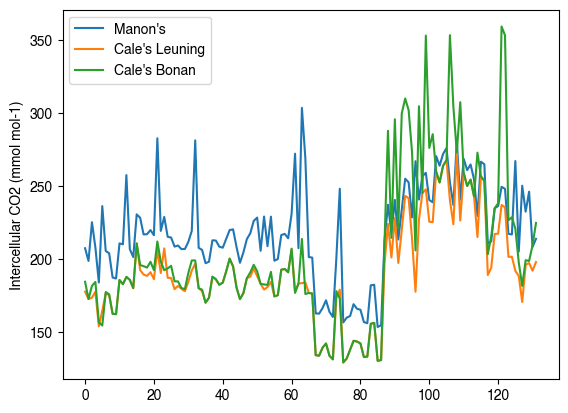

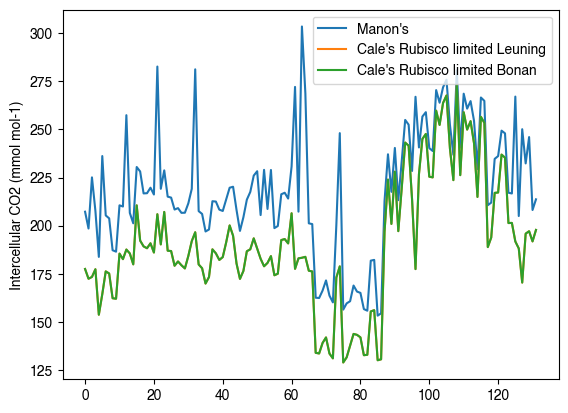

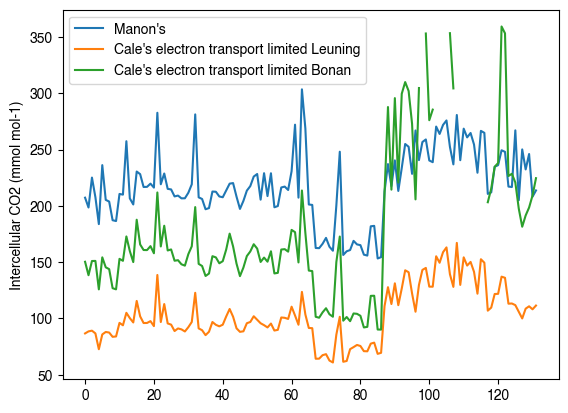

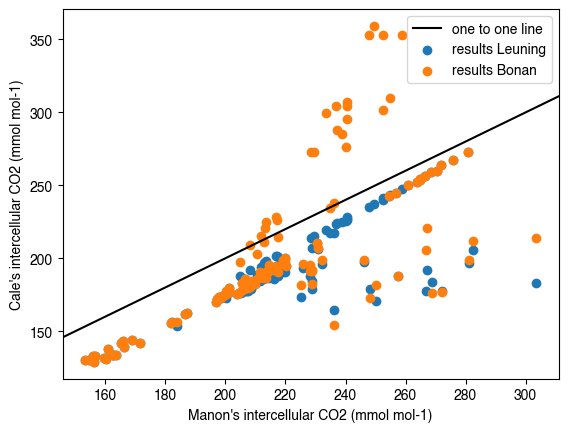

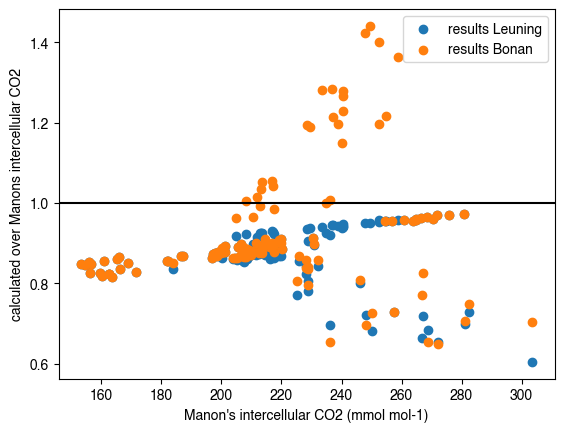

Mean ratio:  0.871685196915505
STD of ratio:  0.0708648685318832


In [30]:
Rubisco_limited_Ci = np.zeros(len(Manons_results))
electron_transport_limited_Ci = np.zeros(len(Manons_results))

for i in range(len(input_data)):
    Rubisco_limited_Ci[i] = photosynthesis_rubisco_limited_model.intercellular_CO2_concentration(Manons_results['gs(pmax)'].iloc[i],
                                                                                                 input_data['CO2'].iloc[i],
                                                                                                 input_data['Tleaf'].iloc[i],
                                                                                                 intercellular_oxygen,
                                                                                                 input_data['PPFD'].iloc[i])
    
    electron_transport_limited_Ci[i] = photosynthesis_electron_transport_limited_model.intercellular_CO2_concentration(Manons_results['gs(pmax)'].iloc[i],
                                                                                                                       input_data['CO2'].iloc[i],
                                                                                                                       input_data['Tleaf'].iloc[i],
                                                                                                                       intercellular_oxygen,
                                                                                                                       input_data['PPFD'].iloc[i])

recalculated_Ci = np.nanmax([Rubisco_limited_Ci, electron_transport_limited_Ci], axis = 0)

# Plot intercellular CO2
plt.plot(x, Manons_results['Ci(pmax)'].to_numpy(), label = "Manon's")
plt.plot(x, intercellular_CO2[:,0,0], label = "Cale's Leuning")
plt.plot(x, intercellular_CO2[:,0,1], label = "Cale's Bonan")
#plt.plot(x, recalculated_Ci, label = "Recalculated")
plt.ylabel("Intercellular CO2 (mmol mol-1)")
plt.legend()
plt.show()

plt.plot(x, Manons_results['Ci(pmax)'].to_numpy(), label = "Manon's")
plt.plot(x, intercellular_CO2[:,1,0], label = "Cale's Rubisco limited Leuning")
plt.plot(x, intercellular_CO2[:,1,1], label = "Cale's Rubisco limited Bonan")
#plt.plot(x, Rubisco_limited_Ci, label = "Rubisco limited Leuning")
plt.ylabel("Intercellular CO2 (mmol mol-1)")
plt.legend()
plt.show()

plt.plot(x, Manons_results['Ci(pmax)'].to_numpy(), label = "Manon's")
plt.plot(x, intercellular_CO2[:,2,0], label = "Cale's electron transport limited Leuning")
plt.plot(x, intercellular_CO2[:,2,1], label = "Cale's electron transport limited Bonan")
#plt.plot(x, electron_transport_limited_Ci, label = "electron transport limited Leuning")
plt.ylabel("Intercellular CO2 (mmol mol-1)")
plt.legend()
plt.show()

plt.axline([200,200], slope = 1, c = 'black', label = 'one to one line')
plt.scatter(Manons_results['Ci(pmax)'].to_numpy(), intercellular_CO2[:,0,0], label = 'results Leuning')
plt.scatter(Manons_results['Ci(pmax)'].to_numpy(), intercellular_CO2[:,0,1], label = 'results Bonan')
plt.legend()
plt.xlabel("Manon's intercellular CO2 (mmol mol-1)")
plt.ylabel("Cale's intercellular CO2 (mmol mol-1)")
plt.show()


plt.scatter(Manons_results['Ci(pmax)'], intercellular_CO2[:,0,0]/Manons_results['Ci(pmax)'], label = 'results Leuning')
plt.scatter(Manons_results['Ci(pmax)'], intercellular_CO2[:,0,1]/Manons_results['Ci(pmax)'], label = 'results Bonan')
plt.legend()
plt.xlabel("Manon's intercellular CO2 (mmol mol-1)")
plt.ylabel("calculated over Manons intercellular CO2")
plt.axline([200,1], slope = 0., c = 'black')
#plt.axline([200,0.9], slope = 0., c = 'black')
plt.show()

print("Mean ratio: ", np.mean(intercellular_CO2[:,0,0]/Manons_results['Ci(pmax)']))
print("STD of ratio: ", np.std (intercellular_CO2[:,0,0]/Manons_results['Ci(pmax)']))

## Net CO2 uptake

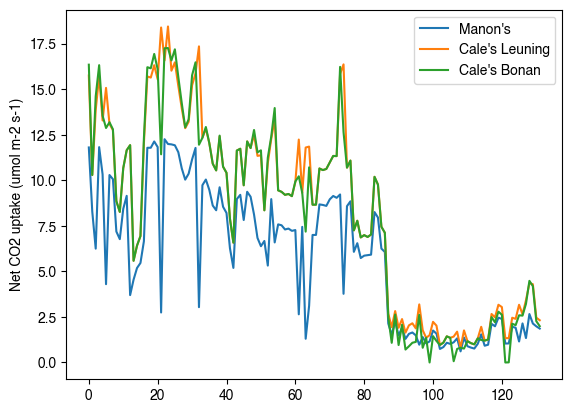

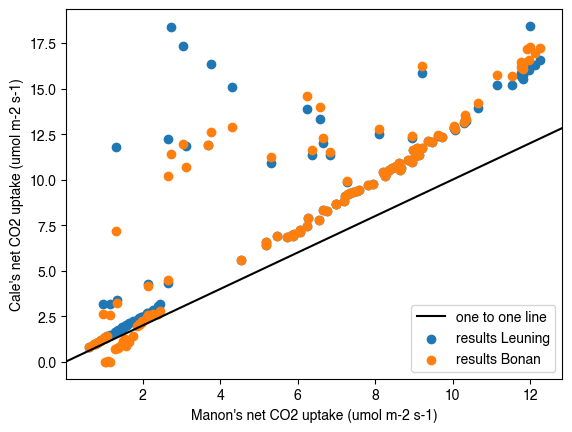

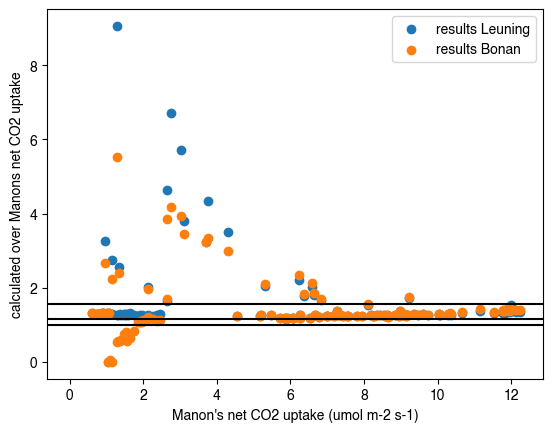

Mean ratio Leuning:  1.586314001703395
STD of ratio Leuning:  1.0464559376383025
Mean ratio Bonan:  1.3994579019727773
STD of ratio Bonan:  0.7483144775423024


In [31]:
calculated_net_CO2_uptake = (input_data['CO2'].to_numpy() - Manons_results['Ci(pmax)'].to_numpy())*Manons_results['gw(pmax)'].to_numpy()/1.57

# Plot net CO2 uptake
plt.plot(x, Manons_results['A(pmax)'].to_numpy(), label = "Manon's")
plt.plot(x, net_CO2_uptake[:,0,0], label = "Cale's Leuning")
plt.plot(x, net_CO2_uptake[:,0,1], label = "Cale's Bonan")
#plt.plot(x, calculated_net_CO2_uptake, label = "Recalculated")
plt.ylabel("Net CO2 uptake (umol m-2 s-1)")
plt.legend()
plt.show()

plt.axline([2,2], slope = 1, c = 'black', label = 'one to one line')
plt.scatter(Manons_results['A(pmax)'].to_numpy(), net_CO2_uptake[:,0,0], label = 'results Leuning')
plt.scatter(Manons_results['A(pmax)'].to_numpy(), net_CO2_uptake[:,0,1], label = 'results Bonan')
plt.legend()
plt.xlabel("Manon's net CO2 uptake (umol m-2 s-1)")
plt.ylabel("Cale's net CO2 uptake (umol m-2 s-1)")
plt.show()

plt.scatter(Manons_results['A(pmax)'], net_CO2_uptake[:,0,0]/Manons_results['A(pmax)'], label = "results Leuning")
plt.scatter(Manons_results['A(pmax)'], net_CO2_uptake[:,0,1]/Manons_results['A(pmax)'], label = "results Bonan")
plt.legend()
plt.xlabel("Manon's net CO2 uptake (umol m-2 s-1)")
plt.ylabel("calculated over Manons net CO2 uptake")
plt.axline([0,1], slope = 0., c = 'black')
plt.axline([0,1.57], slope = 0., c = 'black')
plt.axline([0,1.15], slope = 0., c = 'black')
plt.show()


print("Mean ratio Leuning: ", np.mean(net_CO2_uptake[:,0,0]/Manons_results['A(pmax)']))
print("STD of ratio Leuning: ", np.std (net_CO2_uptake[:,0,0]/Manons_results['A(pmax)']))

print("Mean ratio Bonan: ", np.mean(net_CO2_uptake[:,0,1]/Manons_results['A(pmax)']))
print("STD of ratio Bonan: ", np.std (net_CO2_uptake[:,0,1]/Manons_results['A(pmax)']))